## Taller Arboles de decision
##### Monitor: Juan Nicolas Piedrahita Salas

#### Introducción a la inteligencia artificial 2023-01

Este dataset contiene información sobre reclutamiento de personal. El objetivo es predecir si un candidato será contratado o no. (dataset previamente limpiado)

### Importar librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('ggplot')

## Lectura de datos

In [ ]:
X = pd.read_csv("X_recruitment_data.csv")
y = pd.read_csv("y_recruitment_data.csv").squeeze()

display(X, y)

,Gender,Python_exp,Experience_Years,Education,Internship,Score,Salary * 10E4,Offer_History,Location
0,Male,Yes,0.0,Graduate,No,5139,0.0,Yes,Urban
1,Male,No,1.0,Graduate,No,4583,128.0,Yes,Rural
2,Male,No,0.0,Graduate,Yes,3000,66.0,Yes,Urban
3,Male,No,0.0,Not Graduate,No,2583,120.0,Yes,Urban
4,Male,Yes,0.0,Graduate,No,6000,141.0,Yes,Urban
...,...,...,...,...,...,...,...,...,...
609,Female,Yes,0.0,Graduate,No,2900,71.0,Yes,Rural
610,Male,No,3.0,Graduate,No,4106,40.0,Yes,Rural
611,Male,No,1.0,Graduate,No,8072,253.0,Yes,Urban
612,Male,No,2.0,Graduate,No,7583,187.0,Yes,Urban


0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Recruitment_Status, Length: 614, dtype: int64

#### informacion del dataset

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            614 non-null    object 
 1   Python_exp        614 non-null    object 
 2   Experience_Years  614 non-null    float64
 3   Education         614 non-null    object 
 4   Internship        614 non-null    object 
 5   Score             614 non-null    int64  
 6   Salary * 10E4     614 non-null    float64
 7   Offer_History     614 non-null    object 
 8   Location          614 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 43.3+ KB


In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 614 entries, 0 to 613
Series name: Recruitment_Status
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 4.9 KB


#### existen filas duplicadas?

In [ ]:
X.duplicated().any()

False

## Exploracion de datos

#### estadisticas descriptivas

In [ ]:
X.describe()

,Experience_Years,Score,Salary * 10E4
count,614.000000,614.000000,614.000000
mean,0.744300,5402.302932,146.165261
std,1.009623,6109.024398,84.244922
min,0.000000,150.000000,0.000000
25%,0.000000,2877.500000,100.000000
50%,0.000000,3812.500000,128.500000
75%,1.000000,5771.500000,164.750000
max,3.000000,81000.000000,700.000000


#### como se distribuyen las variables categoricas segun su `Recruitment_Status` 

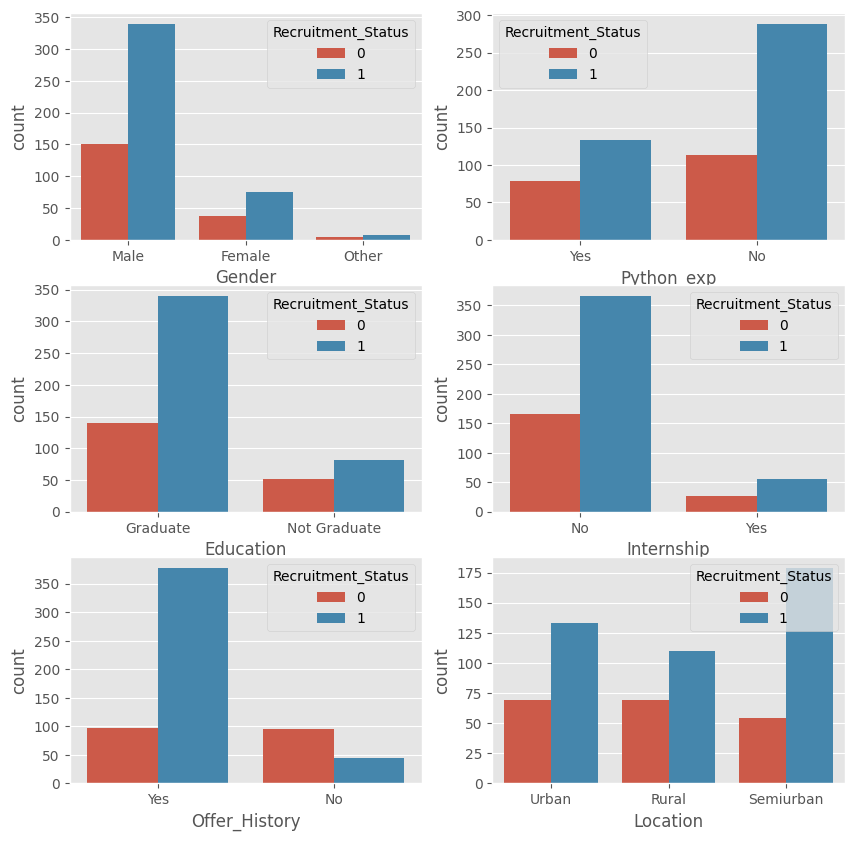

In [ ]:
cat_cols = X.select_dtypes(include=['object']).columns.to_list()

X_y = pd.concat([X, y], axis=1)

_, ax = plt.subplots(3, len(cat_cols)//3, figsize=(10, 10))

ax = ax.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=X_y, x=col, ax=ax[i], hue='Recruitment_Status')

plt.show()

#### como se distribuyen las variables numericas segun su `Recruitment_Status` 

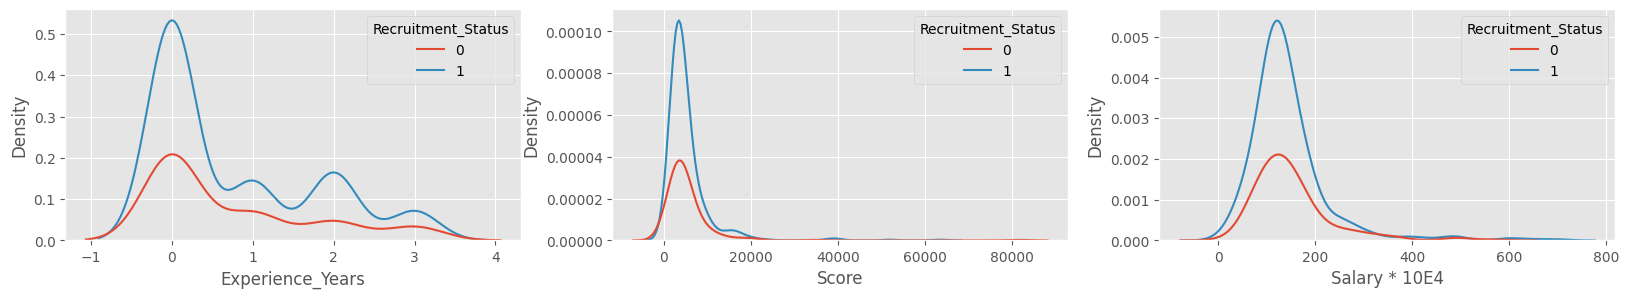

In [ ]:
num_cols = X.select_dtypes(include=[np.number]).columns.to_list()

_, ax = plt.subplots(1, len(num_cols), figsize=(20, 3))

for i, col in enumerate(num_cols):
    sns.kdeplot(data=X_y, x=col, ax=ax[i], hue='Recruitment_Status')

plt.show()

### variable objetivo

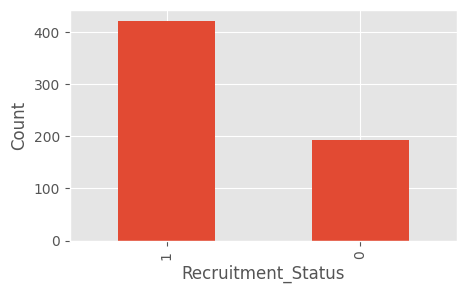

In [ ]:
y.value_counts().plot.bar(figsize=(5, 3))

plt.xlabel("Recruitment_Status")
plt.ylabel("Count")
plt.show()

## Preparacion para la clasificacion

#### encoding de las variables que lo necesiten

para esto usaremos `ColumnEncoder` de `Sklearn.compose`

Esta clase nos permite hacer el transformaciones a varias columnas de una sola vez, a demas de poder hacer las mismas transformaciones a valores futuros

Esta clase recibe una lista de tuplas con la estructura: **(nombre transformacion, Transformador, lista de columnas a transformar)**, y nos devuelve una matriz con los datos codificados segun los transformadores que hallamos definido

si queremos recuperar los nombres de las columnas de la matriz podemos usar el metodo `get_feature_names_out()`

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = ["Gender", "Python_exp", "Education", "Internship", "Location", "Offer_History"]

ColTransformer = ColumnTransformer(
        transformers = [
                ("cat_data_encoding", OrdinalEncoder(), categorical_cols),
                ("other_data", "passthrough", X.columns.difference(categorical_cols))
        ],
        verbose_feature_names_out = False
        )

X_encoded = ColTransformer.fit_transform(X)

X_encoded

array([[1.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        5.139e+03],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.280e+02,
        4.583e+03],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 6.600e+01,
        3.000e+03],
       ...,
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.530e+02,
        8.072e+03],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 2.000e+00, 1.870e+02,
        7.583e+03],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 1.330e+02,
        4.583e+03]])

### Seleccion de caracteristicas para la clasificacion

#### matriz de correlaciones para variables categoricas

para establecer una correlacion entre las variables categoricas es preferible usar la correlacion de CramersV, este valor se mueve entre `[0, 1]`, siendo valores cercanos a 1 que las dos variables estan correlacionadas y valores cercanos a 0 que no lo estan

In [ ]:
def cramers_V(df):
    def get_cramersV_corr(var1, var2):
        from scipy.stats import chi2_contingency
        crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
        stat = chi2_contingency(crosstab)[0]
        obs = np.sum(crosstab)
        mini = min(crosstab.shape) - 1
        return (stat/(obs*mini))
    

    rows= []
    for var1 in df.columns:
        col = []
        for var2 in df.columns:
            cramers = get_cramersV_corr(df[var1], df[var2])
            col.append(round(cramers,2))
        rows.append(col)

    return pd.DataFrame(rows, columns=df.columns, index=df.columns)

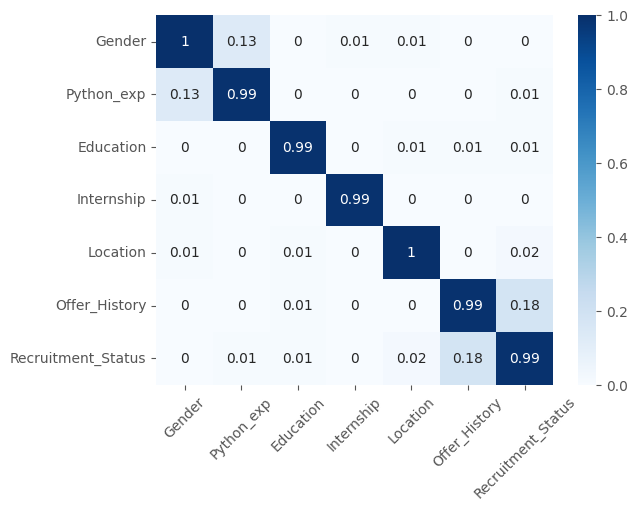

In [ ]:
categorical_cols = ["Gender", "Python_exp", "Education", "Internship", "Location", "Offer_History", "Recruitment_Status"]

sns.heatmap( cramers_V(X_y[categorical_cols]) , annot=True, cmap="Blues")

plt.xticks(rotation=45)
plt.show()

#### matriz de correlaciones para variables numericas

para establecer una correlacion **lineal** entre las variables numericas usaremos la correlacion de Pearson, este valor se mueve entre `[-1, 1]`, siendo valores cercanos a 1 o -1 que las dos variables estan correlacionadas y valores cercanos a 0 que no lo estan

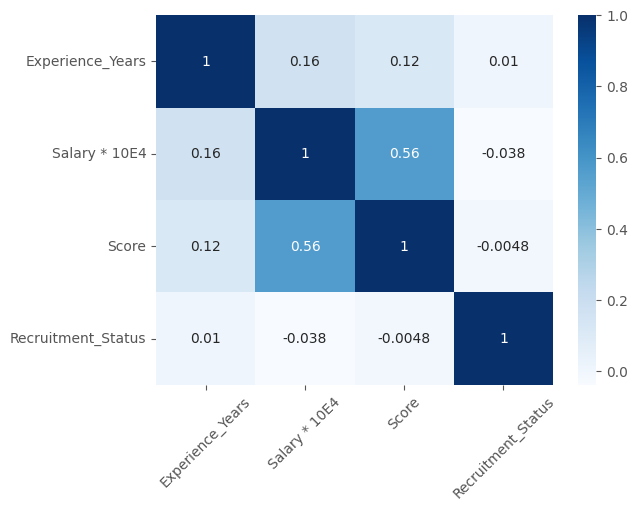

In [ ]:
numerical_cols = ['Experience_Years', 'Salary * 10E4', 'Score', "Recruitment_Status"]

sns.heatmap( X_y[numerical_cols].corr() , annot=True, cmap="Blues")

plt.xticks(rotation=45)
plt.show()

#### SelectKBest

Selecciona las K caracteristicas que mas peso tienen en la clasificacion (basado en una funcion de scoring, por defecto `f_classif`)

tambien podemos pasarle el parametro `k=all` para ver el peso que tiene en la clasificacion todas las variables

In [ ]:
from sklearn.feature_selection import SelectKBest

kbest = SelectKBest(k="all").fit(X_encoded, y)

pd.Series(kbest.scores_, index=ColTransformer.get_feature_names_out()).sort_values()

Internship            0.008380
Score                 0.014321
Gender                0.046215
Experience_Years      0.062665
Location              0.631733
Salary * 10E4         0.893959
Education             4.547685
Python_exp            5.164552
Offer_History       140.912799
dtype: float64

#### Separar los datos en entrenamiento y prueba

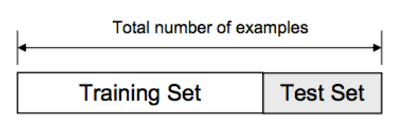

para esto usaremos `train_test_split` de la libreria `sklearn.model_selection`

dependiendo de la cantidad de datos que se tengan puede ser recomendable usar mas o menos datos para el entrenamiento, pueden probar con diferentes valores para `train_size` y ver como cambia el resultado

In [ ]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size= 0.25)

#### balanceo de clases

los arboles de decision tienen un parametro llamado `class_weight` que nos balancea las clases automaticamente, dandole mas peso en la clasificaccion a las clases con mayor peso.

- **pasarle al parametro `class_weight` un diccionario con los pesos para cada clase**

<center>

nostros tenemos que las clases se distribuyen

|clase|conteo|
|-----|------|
|1|422|
|0|192|

por lo que podemos pasarle un diccionario con los siguientes pesos

`class_weight = {1: 1, 0: w}` 

donde por convención $w = \frac{422}{192} = 2.197$

</center>



- **pasarle al parametro `class_weight` la palabra clave `balanced`**

    con este valor, el arbol de decision automaticamente les dara los pesos a las clases usando la siguiente formula:

    `n_samples / (n_classes * np.bincount(y))`

- **Tambien podemos usar los metodos anteriormente mencionados (recordar hacer el balanceo de clases solo en el dataset de entrenamiento, para evitar introducir fugas de datos)**

#### evaluacion de parametros del modelo

usaremas `GridSearchCV` de la libreria `sklearn.model_selection` para evaluar los parametros del modelo

esta clase nos permite crear un **grid** en el que se van a buscar la combinacion de parametros que optimizan una metrica, por defecto optimiza el `accurracy`.

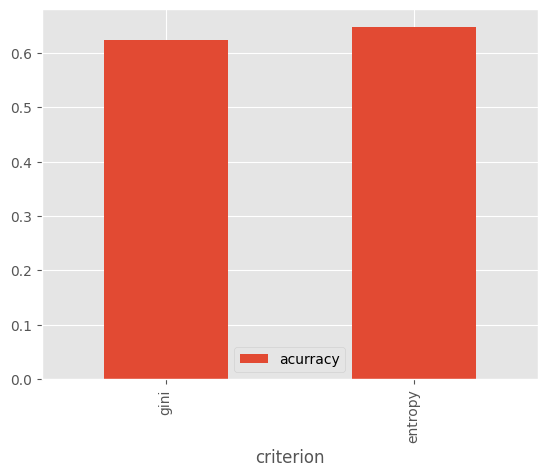

In [ ]:
# evaluar criterion
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

grid = {"criterion": ["gini", "entropy"]}
criterion_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight={1:1, 0:2.197}),
    param_grid = grid
)
criterion_model.fit(X_train, y_train)


df_results = pd.DataFrame(criterion_model.cv_results_["params"])
df_results["acurracy"] = criterion_model.cv_results_["mean_test_score"]

df_results.plot.bar(x="criterion", y="acurracy")

plt.show()

#### altura del arbol

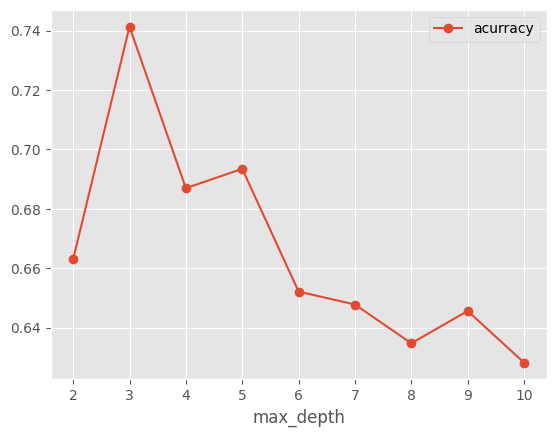

In [ ]:
# evaluar altura del arbol
grid = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10]}
max_depth_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight={1:1, 0:2.197}),
    param_grid = grid
)
max_depth_model.fit(X_train, y_train)


df_results = pd.DataFrame(max_depth_model.cv_results_["params"])
df_results["acurracy"] = max_depth_model.cv_results_["mean_test_score"]

df_results.plot.line(x="max_depth", y="acurracy", marker="o")

plt.show()

#### min_samples_split

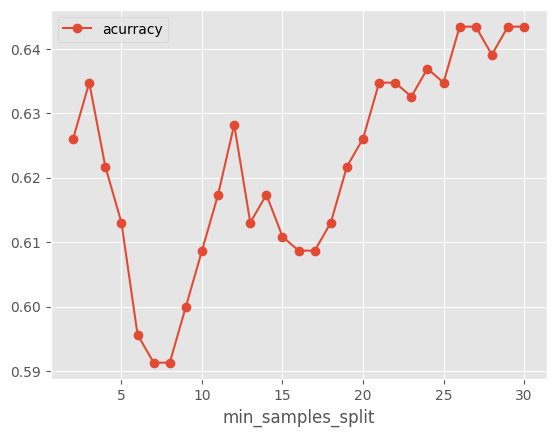

In [ ]:
#  evaluar min_samples_split
grid = {"min_samples_split": range(2, 30 + 1)}
min_samples_split_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight={1:1, 0:2.197}),
    param_grid = grid
)
min_samples_split_model.fit(X_train, y_train)


df_results = pd.DataFrame(min_samples_split_model.cv_results_["params"])
df_results["acurracy"] = min_samples_split_model.cv_results_["mean_test_score"]

df_results.plot.line(x="min_samples_split", y="acurracy", marker="o")

plt.show()

#### min_samples_leaf

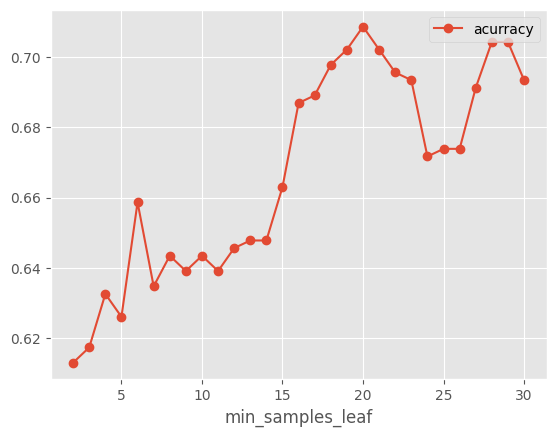

In [ ]:
# evaluar min_samples_leaf
grid = {"min_samples_leaf": range(2, 30 + 1)}
min_samples_leaf_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight={1:1, 0:2.197}),
    param_grid = grid
)
min_samples_leaf_model.fit(X_train, y_train)


df_results = pd.DataFrame(min_samples_leaf_model.cv_results_["params"])
df_results["acurracy"] = min_samples_leaf_model.cv_results_["mean_test_score"]

df_results.plot.line(x="min_samples_leaf", y="acurracy", marker="o")

plt.show()

#### todos a la vez

In [ ]:
# evaluar todas a la vez 
# (tener cuidado de tener demasiadas variaciones para los parametros, ya que debe entrenar 1 modelo por cada combinacion)
# 2 x 9 x 18 x 28 = 9.072 modelos a entrenar !!

grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_split": range(2, 20 + 1),
    "min_samples_leaf": range(2, 30 + 1),
}

all_model = GridSearchCV(
    estimator = DecisionTreeClassifier(class_weight={1:1, 0:2.197}),
    param_grid = grid
)
all_model.fit(X_train, y_train)

print("mejores parametros =", all_model.best_params_,)

print("mejor accurracy =", all_model.best_score_)

mejores parametros = {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
mejor accurracy = 0.7434782608695653


## entrenamieto del modelo

In [ ]:
# entrenar con los mejores hiperparametros

modelo = DecisionTreeClassifier(
    criterion="gini",
    max_depth=2,
    min_samples_leaf=2,
    min_samples_split=2,
    class_weight={1:1, 0:2.197}
)

modelo.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 2.197, 1: 1}, max_depth=2,
                       min_samples_leaf=2)

In [ ]:
# mostrar imagen del arbol
def Mostrar_Arbol(modelo, nombres_caract):
    from sklearn.tree import export_graphviz
    from subprocess import check_call
    from PIL import Image, ImageDraw, ImageFont
    from IPython.display import Image as PImage

    with open(r"tree1.dot", 'w') as f:
        f = export_graphviz(modelo,
                            out_file=f,
                            max_depth = 4,
                            impurity = True,
                            feature_names = nombres_caract,
                            class_names = list(map(str, modelo.classes_)),
                            rounded = True,
                            filled= True)
            
    # Convertir el archivo .dot a png para poder visualizarlo
    check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
    return PImage("tree1.png")

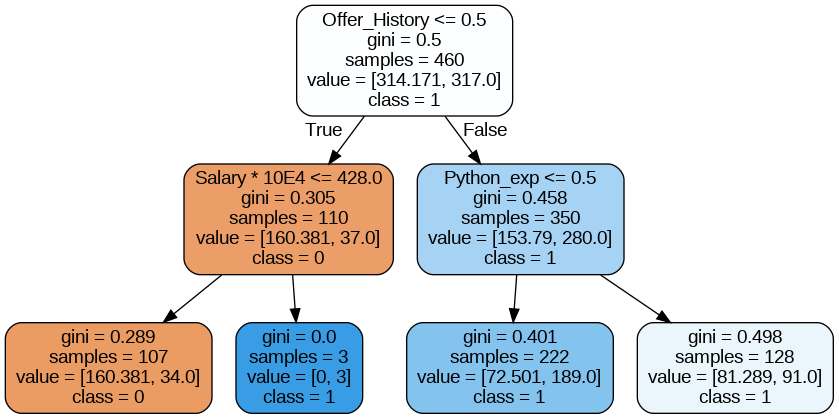

In [ ]:
Mostrar_Arbol(modelo, ColTransformer.get_feature_names_out())

## evaluacion del modelo

#### exacitud del modelo

In [ ]:
print("exactitud para el entrenamiento =", modelo.score(X_train, y_train))
print("exactitud para prueba =", modelo.score(X_test, y_test))

exactitud para el entrenamiento = 0.7739130434782608
exactitud para prueba = 0.7727272727272727


#### matrices de confusion

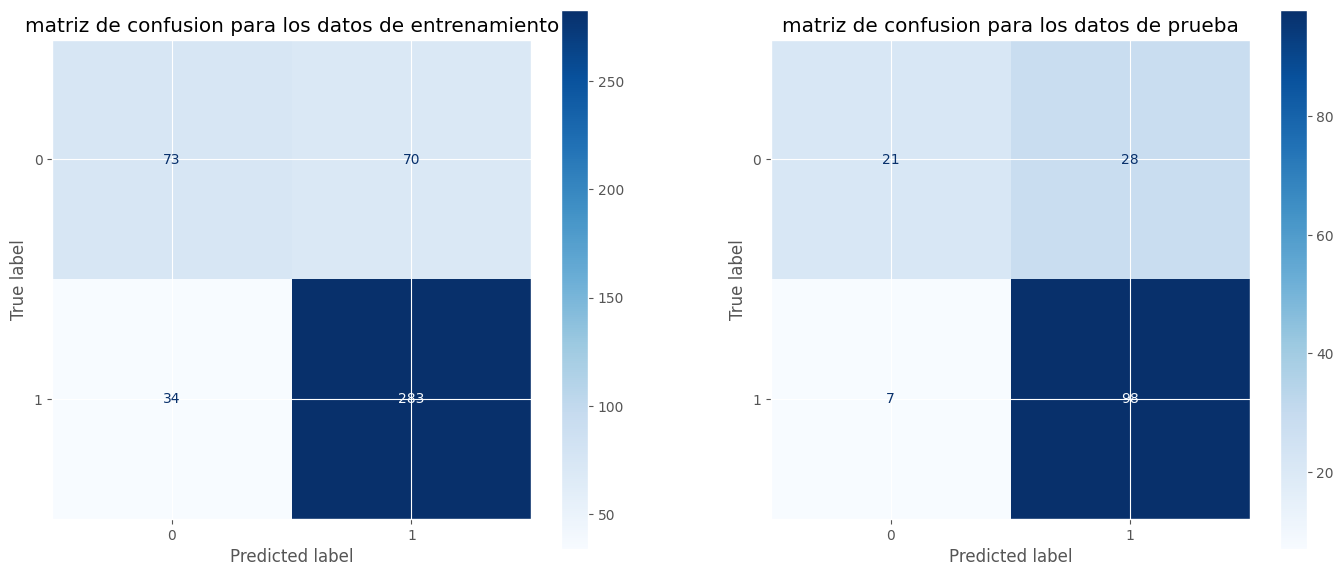

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

cmTrain = ConfusionMatrixDisplay.from_estimator(
    estimator = modelo,
    X = X_train,
    y = y_train,
    cmap = "Blues",
    ax = ax1
)

cmTest = ConfusionMatrixDisplay.from_estimator(
    estimator = modelo,
    X = X_test,
    y = y_test,
    cmap="Blues",
    ax = ax2
)

cmTrain.ax_.set_title("matriz de confusion para los datos de entrenamiento")
cmTest.ax_.set_title("matriz de confusion para los datos de prueba")

plt.show()

#### resumen de metricas

la libreria `sklearn` nos ofrece el metodo `classification_report`, el cual nos da el resumen de todas las metricas que han visto en clase

In [ ]:
from sklearn.metrics import classification_report

print("Metricas para datos de entrenamiento")
print(classification_report(y_train, modelo.predict(X_train)))

print("//////////////////////////////////////////////////////")

print("Metricas para datos de prueba")
print(classification_report(y_test, modelo.predict(X_test)))

Metricas para datos de entrenamiento
              precision    recall  f1-score   support

           0       0.68      0.51      0.58       143
           1       0.80      0.89      0.84       317

    accuracy                           0.77       460
   macro avg       0.74      0.70      0.71       460
weighted avg       0.76      0.77      0.76       460

//////////////////////////////////////////////////////
Metricas para datos de prueba
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        49
           1       0.78      0.93      0.85       105

    accuracy                           0.77       154
   macro avg       0.76      0.68      0.70       154
weighted avg       0.77      0.77      0.75       154



## prediccion de datos futuros

In [ ]:
prediccion_futura = pd.DataFrame({
    'Gender': 'Male',               # 'Male', 'Female', 'Other'
    'Python_exp': 'Yes',            # 'Yes', 'No'
    'Experience_Years': 5,
    'Education': 'Not Graduate',    # 'Graduate', 'Not Graduate'
    'Internship': 'No',             # 'No', 'Yes'
    'Score': X["Score"].mean(),
    'Salary * 10E4': 1200*12 / 10E4,
    'Offer_History': 'Yes',         # 'Yes', 'No'
    'Location': 'Urban'             # 'Urban', 'Rural', 'Semiurban'
}, index=[0])

valor_futuro = ColTransformer.transform(prediccion_futura)

modelo.predict(valor_futuro)

array([1])

# clasificacion bayesiana

#### entrenamiento del modelo

In [ ]:
from sklearn.naive_bayes import GaussianNB
modeloGB = GaussianNB().fit(X_train, y_train)

#### exactitud del modelo

In [ ]:
print("exactitud para el entrenamiento =", modeloGB.score(X_train, y_train))
print("exactitud para prueba =", modeloGB.score(X_test, y_test))

exactitud para el entrenamiento = 0.7739130434782608
exactitud para prueba = 0.7597402597402597


#### matrices de confusion

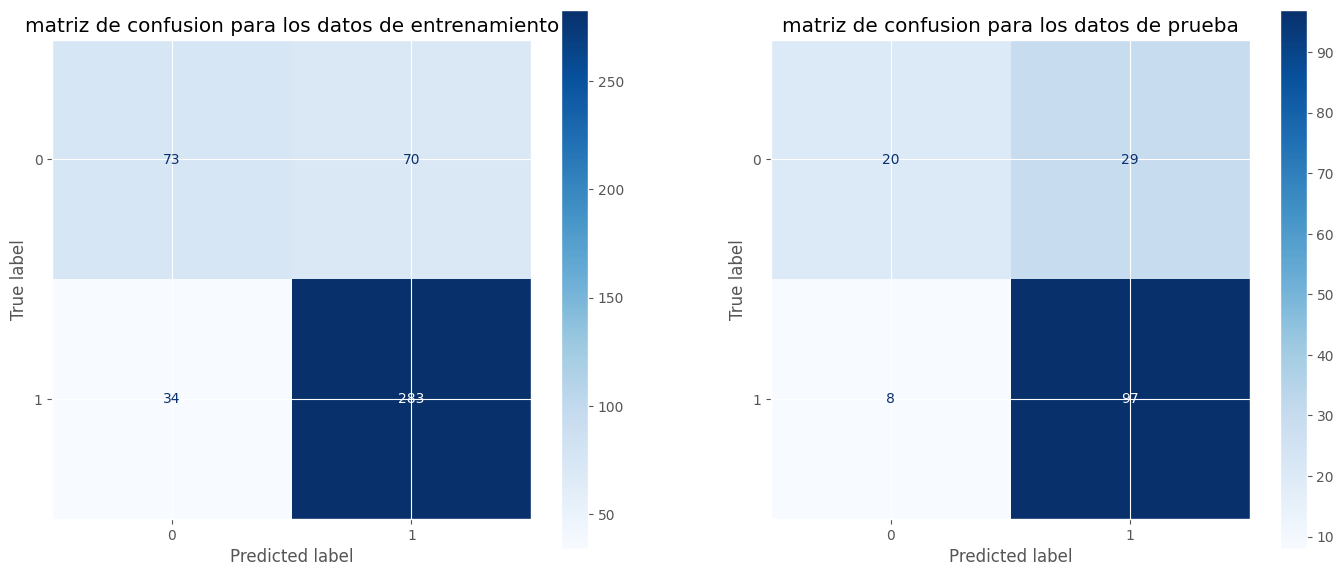

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

cmTrain = ConfusionMatrixDisplay.from_estimator(
    estimator = modeloGB,
    X = X_train,
    y = y_train,
    cmap = "Blues",
    ax = ax1
)

cmTest = ConfusionMatrixDisplay.from_estimator(
    estimator = modeloGB,
    X = X_test,
    y = y_test,
    cmap="Blues",
    ax = ax2
)

cmTrain.ax_.set_title("matriz de confusion para los datos de entrenamiento")
cmTest.ax_.set_title("matriz de confusion para los datos de prueba")

plt.show()

#### resumen de metricas

In [ ]:
from sklearn.metrics import classification_report

print("Metricas para datos de entrenamiento")
print(classification_report(y_train, modeloGB.predict(X_train)))

print("//////////////////////////////////////////////////////")

print("Metricas para datos de prueba")
print(classification_report(y_test, modeloGB.predict(X_test)))

Metricas para datos de entrenamiento
              precision    recall  f1-score   support

           0       0.68      0.51      0.58       143
           1       0.80      0.89      0.84       317

    accuracy                           0.77       460
   macro avg       0.74      0.70      0.71       460
weighted avg       0.76      0.77      0.76       460

//////////////////////////////////////////////////////
Metricas para datos de prueba
              precision    recall  f1-score   support

           0       0.71      0.41      0.52        49
           1       0.77      0.92      0.84       105

    accuracy                           0.76       154
   macro avg       0.74      0.67      0.68       154
weighted avg       0.75      0.76      0.74       154

